In [33]:
import inferno
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset
from torch.autograd import Variable

In [15]:
from sine_data import train_dataset, valid_dataset

In [214]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import insp

In [241]:
X_train, y_train = train_dataset(points=200)
X_train, y_train = torch.Tensor(X_train), torch.LongTensor(y_train)

X_valid, y_valid = valid_dataset(points=400)
X_valid, y_valid = torch.Tensor(X_valid), torch.LongTensor(y_valid)

sine_train_loader = DataLoader(TensorDataset(X_train, y_train),
                               batch_size=64,
                               shuffle=True)
sine_valid_loader = DataLoader(TensorDataset(X_valid, y_valid),
                               batch_size=64,
                               shuffle=False)

In [298]:
class InhCWRNN(nn.Module):
    def __init__(self, input_dim, output_dim, num_modules, inhibition='sigmoid', *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_modules = num_modules
        
        self.input_mod = nn.Linear(input_dim, output_dim)
        self.input_inh = nn.Linear(input_dim, output_dim)
        
        self.hidden_mod = nn.Linear(output_dim, output_dim, bias=False)
        self.hidden_inh = nn.Linear(output_dim, output_dim, bias=False)
        
        self.f_mod = nn.Tanh()
        
        self.inhibition = inhibition
        
    def step(self, xi, h):
        module_size = self.output_dim // self.num_modules
        
        acts = self.f_mod(self.input_mod(xi) + self.hidden_mod(h))
        inhs = self.input_inh(xi) + self.hidden_inh(h)
        
        module_acts = acts.view(-1, self.num_modules, module_size)
        module_inhs = inhs.view(-1, self.num_modules, module_size)
        
        if self.inhibition == 'relu':
            y = F.relu6(module_acts - module_inhs.sum(-1, keepdim=True))
            y = y.view(-1, self.output_dim)
            idx = (y == 0)
            hh = h.expand_as(y)
            y[idx] = hh[idx]
            return acts,y
        
        elif self.inhibition == 'sigmoid':
            gate = F.sigmoid(module_acts - module_inhs.sum(-1, keepdim=True))
            gate = gate.view(-1, self.output_dim)

            y = gate * acts + (1 - gate) * h        
            return y, y
        
        raise ValueError('Unknown inhibition mode {}'.format(self.inhibition))

    def init_hidden(self):
        return Variable(torch.zeros(self.output_dim))
        
    def forward(self, x):
        t = x.size(1)
        ys = []
        h = self.init_hidden()
        for ti in range(t):
            xi = x[:, ti]
            yi, h = self.step(xi, h)
            ys.append(yi)
        return torch.stack(ys, dim=1), h

In [299]:
def time_flatten(t):
    return t.view(t.size(0) * t.size(1), -1)

def time_unflatten(t, s):
    return t.view(s[0], s[1], -1)

In [300]:
class ReconModel(nn.Module):
    def __init__(self, num_hidden=64, num_modules=8, inhibition='sigmoid'):
        super().__init__()
        
        self.rnn = InhCWRNN(1, num_hidden, num_modules, inhibition=inhibition)
        self.clf = nn.Linear(num_hidden, 1)
        
    def forward(self, x):
        l0, _ = self.rnn(x)
        l1 = self.clf(time_flatten(l0))
        return time_unflatten(l1, x.size())

In [301]:
class Trainer(inferno.NeuralNet):
    def __init__(self, 
                 criterion=nn.MSELoss,
                 *args, 
                 **kwargs):
        super().__init__(*args, criterion=criterion, **kwargs)

    def get_loss(self, y_pred, y_true, X=None, train=False):
        pred = time_flatten(y_pred)
        true = time_flatten(y_true)
        return super().get_loss(pred, true, X=X, train=train)

In [302]:
torch.manual_seed(1337)

### relu inhibition

In [303]:
def my_train_split(X, y):
    return X, X_valid[:, :-1], y, X_valid[:, 1:]

ef_relu = Trainer(module=ReconModel,
             optim=torch.optim.RMSprop,
             lr=0.0005,
             max_epochs=30,
             train_split=my_train_split,
             
             module__num_modules=8,
             module__num_hidden=64,
             module__inhibition='relu'
            )

In [304]:
%pdb off
ef_relu.fit(X_train[:, :-1], X_train[:, 1:])

Automatic pdb calling has been turned OFF
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.0000        0.2177  0.4699
      2        0.6163        0.2672  0.4184
      3        0.3823        0.2999  0.4744
      4        0.4761        2.4430  0.4306
      5        1.9750        0.1877  0.4712
      6        0.2984        0.1334  0.4639
      7        0.2468        0.1304  0.4589
      8        0.1966        0.0895  0.4714
      9        0.1694        0.0744  0.4117
     10        0.1418        0.0595  0.4847
     11        0.1262        0.0519  0.4198
     12        0.1132        0.0440  0.4600
     13        0.1028        0.0471  0.4148
     14        0.0944        0.0332  0.4775
     15        0.0934        0.0820  0.4321
     16        0.1137        0.0690  0.4661
     17        0.1281        0.0957  0.4211
     18        0.1130        0.0725  0.4640
     19        0.1302        0.1084  0.4227
     20        0.1290        0.053

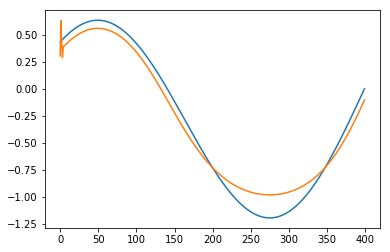

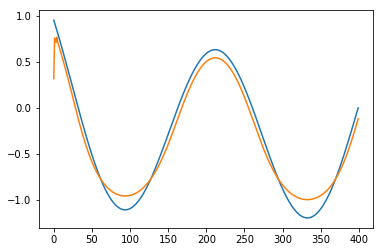

In [305]:
data = X_valid
pred = ef_relu.predict_proba(data)

for i in range(pred.shape[0]):
    plt.figure(i)
    plt.plot(data[i].numpy())
    plt.plot(np.arange(len(pred[i])), pred[i])

### sigmoid inhibition

In [306]:
def my_train_split(X, y):
    return X, X_valid[:, :-1], y, X_valid[:, 1:]

ef_sigmoid = Trainer(module=ReconModel,
             optim=torch.optim.RMSprop,
             lr=0.0005,
             max_epochs=30,
             train_split=my_train_split,
             
             module__num_modules=8,
             module__num_hidden=64,
             module__inhibition='sigmoid'
            )

In [307]:
ef_sigmoid.fit(X_train[:, :-1], X_train[:, 1:])

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.9915        0.2146  0.3441
      2        0.5137        0.0804  0.4238
      3        0.2852        0.0383  0.3628
      4        0.1631        0.0225  0.4223
      5        0.1129        0.0265  0.3704
      6        0.0939        0.0217  0.4229
      7        0.0809        0.0181  0.3661
      8        0.0695        0.0134  0.4293
      9        0.0610        0.0113  0.3625
     10        0.0547        0.0095  0.4119
     11        0.0501        0.0086  0.4346
     12        0.0464        0.0077  0.3648
     13        0.0434        0.0071  0.4197
     14        0.0409        0.0066  0.3705
     15        0.0387        0.0062  0.4220
     16        0.0367        0.0058  0.3636
     17        0.0350        0.0054  0.4086
     18        0.0334        0.0051  0.3581
     19        0.0320        0.0049  0.4236
     20        0.0308        0.0046  0.3569
     21        0.0296        0.0

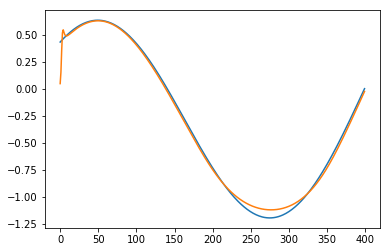

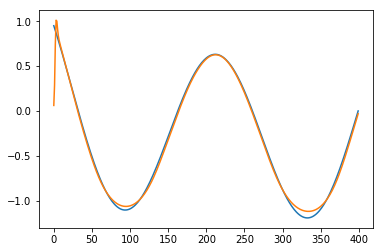

In [308]:
data = X_valid
pred = ef_sigmoid.predict_proba(data)

for i in range(pred.shape[0]):
    plt.figure(i)
    plt.plot(data[i].numpy())
    plt.plot(np.arange(len(pred[i])), pred[i])